# Witch Trials in Saxony-Anhalt

In this notebook, I plot the number of known witch trials for the territory of present-day Saxony-Anhalt. For this I have used:

- the quoted numbers in an article in the website of the project "Frauen Orte",  
- the regional boundaries of cities and villages available at AdV-MIS website.

**Caveats:** some of the places quoted do not necessarily are part of Saxony-Anhalt today, some where incorporated to other bigger cities. I tried to map as best as I could the places quoted to todays boudaries. 




<small>
Source: 

[1] Trials: https://frauenorte.net/frauengeschichten-in-sachsen-anhalt/das-buch-frauenorte/leseproben/hexenverfolgung-in-der-fruehen-neuzeit-auf-dem-gebiet-von-sachsen-anhalt/

[2] Shapefile: https://advmis.geodatenzentrum.de/  

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import matplotlib.image as mpimg
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.transforms as transforms
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable # Create colorbar axis (smaller and at bottom center)

In [2]:
# Mapping the names in the shapefile with the names in the blog 

places_raw = [
    "Aken (Elbe), Stadt",              # "Aken",
    "Ballenstedt, Stadt",              # "Ballenstedt"
    "Barleben",
    "Mansfeld-Südharz",                # "Bennungen" # not in shp file, but is in Mansfeld-Südharz
    "Bernburg (Saale), Stadt",         # "Bernburg" 
    "Coswig (Anhalt), Stadt",          # "Coswig"
    "Blankenburg (Harz), Stadt",       # "Derenburg" # not in shp, but is in Blankenburg (Harz), Stadt
    "Dessau-Roßlau, Stadt",            # "Dessau"
    "Egeln, Stadt",                    # "Egeln"
    "Oberharz am Brocken, Stadt",      # "Elbingerode" # not in shp file, but is in Oberharz am Brocken, Stadt
    "Kelbra (Kyffhäuser), Stadt",      # "Frankenhausen" # not in shp file, but I guess is Bad Frankenhausen, which is in Kelbra (Kyffhäuser), Stadt
    "Gardelegen, Hansestadt",          # "Gardelegen"
    "Gewersleben",                     # not in shp file, I could also not find the place on google/wikipedia
    "Halberstadt, Stadt",              # "Halberstadt"
    "Halberstadt Neindorf",            # not in shp file, but is part of Halberstadt 
    "Gröningen, Stadt",                # "Halberstadt Gröningen"
    "Halberstadt Rohrsheim",           # not in shp file, but is part of Halberstadt
    "Halle (Saale), Stadt",            # "Halle (Saale)"
    "Halle Giebichenstein",            # not in shp file, but is part of Halle (Saale)
    "Ilsenburg (Harz), Stadt",         # "Ilsenburg"
    "Jonitz",                          # not in shp file, is part of Dessau-Roßlau, Stadt
    "Köselitz",                        # not in shp file, but is part of Coswig (Anhalt), Stadt
    "Köthen (Anhalt), Stadt",          # "Köthen"
    "Krimderode",                      # not in shp file, now is part of Nordhausen in Thuringia
    "Magdeburg",
    "Im Mansfeld, Stadt",              # "Mansfeld" # is in Mansfeld-Südharz
    "Naumburg (Saale), Stadt",         # "Naumburg"
    "Niedersachswerfen",               # not in shp, now is part of Nordhausen in Thuringia
    "Oldisleben",                      # not in shp file, now is part of Kyffhäuser district of Thuringia
    "Osterburg (Altmark), Hansestadt", # "Osterburg",
    "Osterwieck, Stadt",               # "Osterode" # not in shp, but is part of Osterwieck, Stadt
    "Petersberg",                      # "Ostrau" # not in shp file, now is part of Petersberg
    "Quedlinburg, Welterbestadt",      # "Quedlinburg"
    "Rossla",                          # not in shp file, but is part of Mansfeld-Südharz
    "Sachsenburg",                     # not in shp file, now is part of Kyffhäuser district in northern Thuringia
    "Sangerhausen, Stadt",             # "Sangerhausen"
    "Schönebeck (Elbe), Stadt",        # "Schönebeck Groß Salze"
    "Schwenda",                        # not in shp file, now is part of Mansfeld-Südharz
    "Stolberg",                        # not in shp, now is part of Mansfeld-Südharz
    "Straßberg",                       # not in shp, but is part of Harzgerode, Stadt
    "Wernigerode, Stadt",              # "Wernigerode"
    "Wittenberg",
    "Zerbst/Anhalt, Stadt",            # "Zerbst"
]

In [3]:
# Mapping the number of trials 

trials = {
    "Aken (Elbe), Stadt": 2,
    "Ballenstedt, Stadt": 6,
    "Barleben": 1,
    "Mansfeld-Südharz": 12,
    "Bernburg (Saale), Stadt": 14,
    "Coswig (Anhalt), Stadt": 4, # 3 + 1 in "Köselitz"
    "Blankenburg (Harz), Stadt": 5,
    "Dessau-Roßlau, Stadt": 16, # 15 + 1 in Jonitz  
    "Egeln, Stadt": 5,
    "Oberharz am Brocken, Stadt": 12,
    "Kelbra (Kyffhäuser), Stadt": 1,
    "Gardelegen, Hansestadt": 7,
    "Gewersleben": 1,
    "Halberstadt, Stadt": 1,
    "Halberstadt Neindorf": 1,
    "Gröningen, Stadt": 20,
    "Halberstadt Rohrsheim": -99, # it only says "several" 
    "Halle (Saale), Stadt": 18,
    "Halle Giebichenstein": 1,
    "Ilsenburg (Harz), Stadt": 2,
    "Jonitz": 1,
    "Köselitz": 1,
    "Köthen (Anhalt), Stadt": 1,
    "Krimderode": 1,
    "Magdeburg": 5,
    "Im Mansfeld, Stadt": 12, # it only says "several", and is part of Mansfeld-Südharz, so I reapeat the number
    "Naumburg (Saale), Stadt": 1,
    "Niedersachswerfen": 1,
    "Oldisleben": 1,
    "Osterburg (Altmark), Hansestadt": 1,
    "Osterwieck, Stadt": 1,
    "Petersberg": 1,
    "Quedlinburg, Welterbestadt": 39,
    "Rossla": 2,
    "Sachsenburg": 1,
    "Sangerhausen, Stadt": 1,
    "Schönebeck (Elbe), Stadt": 13,
    "Schwenda": 1,
    "Stolberg": 8,
    "Straßberg": 1,
    "Wernigerode, Stadt": 52,
    "Wittenberg": 9,
    "Zerbst/Anhalt, Stadt": 2
}

In [4]:
# Reading the shape files

zipfile = "zip://DVG_ALKIS.zip"
regions = gpd.read_file(zipfile)

In [5]:
# Cleaning the names 

regions["name_clean"] = (
    regions["Name"]
    .str.lower()
    .str.replace(r"[^a-zäöüß]", " ", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

In [6]:
regions.head()

,OID,aktualit,Art,Name,RS,AGS,Uebobjekt,ueboname,geometry,name_clean
0,DE15,2025-12-03,Bundesland,Sachsen-Anhalt,15,15,None,None,"MULTIPOLYGON (((670792.942 5674733.939, 670805...",sachsen anhalt
1,DE15001,2025-12-03,Kreis / kreisfreie Stadt,Dessau-Roßlau,15001,15001,DE15,Sachsen-Anhalt,"MULTIPOLYGON (((715765.107 5741285.025, 715753...",dessau roßlau
2,DE150010000000,2025-12-03,Gemeinde,"Dessau-Roßlau, Stadt",150010000000,15001000,DE150010000,"Dessau-Roßlau, Stadt","MULTIPOLYGON (((715807.782 5741281.833, 715803...",dessau roßlau stadt
3,DE15002,2025-12-03,Kreis / kreisfreie Stadt,Halle,15002,15002,DE15,Sachsen-Anhalt,"POLYGON ((699156.752 5706922.213, 699154.336 5...",halle
4,DE150020000000,2025-12-03,Gemeinde,"Halle (Saale), Stadt",150020000000,15002000,DE150020000,"Halle (Saale), Stadt","POLYGON ((699231.022 5706917.566, 699199.420 5...",halle saale stadt


In [7]:
places = pd.Series(places_raw).str.lower()
places = places.str.replace(r"[^a-zäöüß]", " ", regex=True)
places = places.str.replace(r"\s+", " ", regex=True)
places = places.str.strip()
places

0                  aken elbe stadt
1                ballenstedt stadt
2                         barleben
3                 mansfeld südharz
4             bernburg saale stadt
5              coswig anhalt stadt
6           blankenburg harz stadt
7              dessau roßlau stadt
8                      egeln stadt
9        oberharz am brocken stadt
10         kelbra kyffhäuser stadt
11           gardelegen hansestadt
12                     gewersleben
13               halberstadt stadt
14            halberstadt neindorf
15                 gröningen stadt
16           halberstadt rohrsheim
17               halle saale stadt
18            halle giebichenstein
19            ilsenburg harz stadt
20                          jonitz
21                        köselitz
22             köthen anhalt stadt
23                      krimderode
24                       magdeburg
25               im mansfeld stadt
26            naumburg saale stadt
27               niedersachswerfen
28                  

In [8]:
# Checking the name of places in common

found = regions[regions["name_clean"].isin(places)].copy()
missing = places[~places.isin(regions["name_clean"])]

print("Found:")
display(found["Name"])

print("\nMissing:")
display(missing)

Found:


2                 Dessau-Roßlau, Stadt
4                 Halle (Saale), Stadt
5                            Magdeburg
13              Gardelegen, Hansestadt
22                  Aken (Elbe), Stadt
24              Köthen (Anhalt), Stadt
30                Zerbst/Anhalt, Stadt
37                            Barleben
46                    Gröningen, Stadt
90             Naumburg (Saale), Stadt
102                 Ballenstedt, Stadt
103          Blankenburg (Harz), Stadt
107                 Halberstadt, Stadt
112            Ilsenburg (Harz), Stadt
114         Oberharz am Brocken, Stadt
115                  Osterwieck, Stadt
116         Quedlinburg, Welterbestadt
121                 Wernigerode, Stadt
131                   Mansfeld-Südharz
146         Kelbra (Kyffhäuser), Stadt
149                Sangerhausen, Stadt
168                         Petersberg
179            Bernburg (Saale), Stadt
185                       Egeln, Stadt
193           Schönebeck (Elbe), Stadt
211    Osterburg (Altmark


Missing:


12              gewersleben
14     halberstadt neindorf
16    halberstadt rohrsheim
18     halle giebichenstein
20                   jonitz
21                 köselitz
23               krimderode
25        im mansfeld stadt
27        niedersachswerfen
28               oldisleben
33                   rossla
34              sachsenburg
37                 schwenda
38                 stolberg
39                straßberg
dtype: object

In [9]:
found["trials_value"] = found["Name"].map(trials)
found[["Name", "trials_value"]]

,Name,trials_value
2,"Dessau-Roßlau, Stadt",16
4,"Halle (Saale), Stadt",18
5,Magdeburg,5
13,"Gardelegen, Hansestadt",7
22,"Aken (Elbe), Stadt",2
24,"Köthen (Anhalt), Stadt",1
30,"Zerbst/Anhalt, Stadt",2
37,Barleben,1
46,"Gröningen, Stadt",20
90,"Naumburg (Saale), Stadt",1


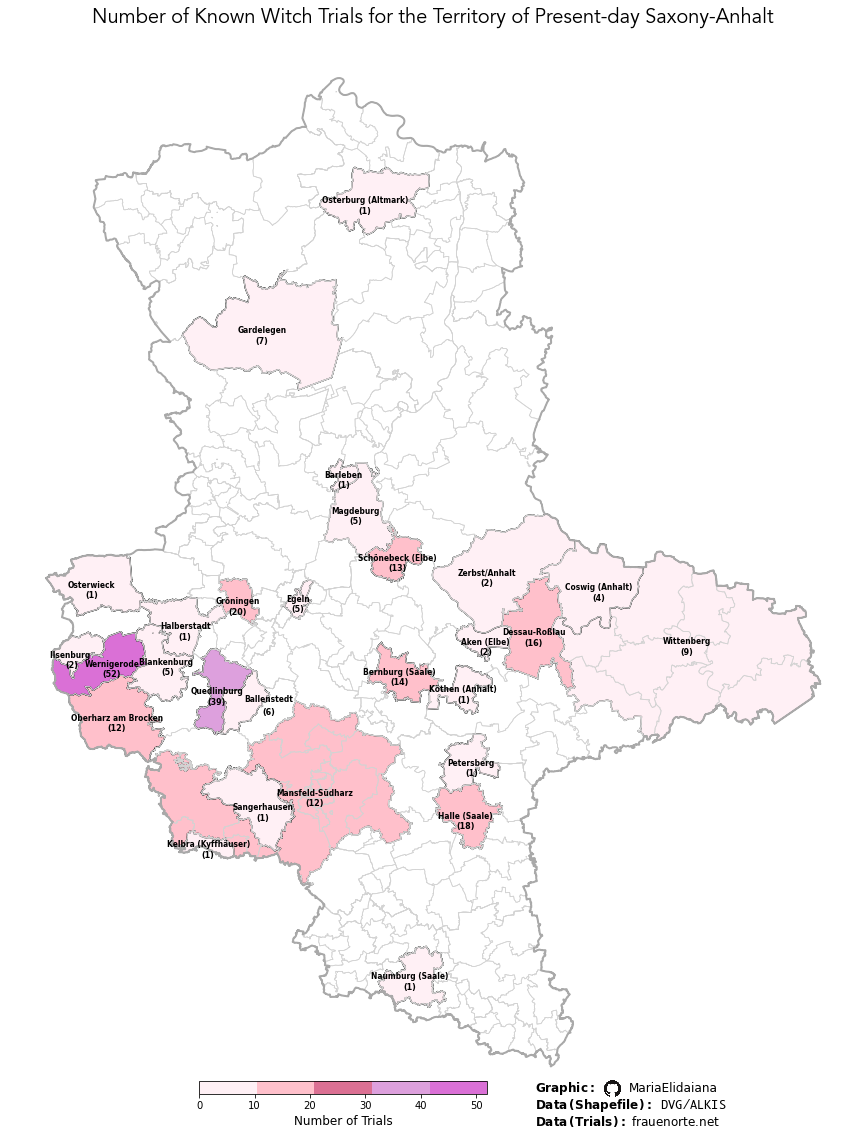

In [10]:
fig, ax = plt.subplots(figsize=(20, 20))

# Dissolve all polygons into a single geometry: gives just the outer boundary, with no internal lines.
regions["__all__"] = 1
outer = regions.dissolve(by="__all__")

# Remove duplicates and plot all internal boundaries
regions_nodup = regions.drop_duplicates(subset="Name")
regions_nodup.boundary.plot(ax=ax, color='lightgray', linewidth=0.75)

# Plot the outer boundary on top with a bold line
outer.boundary.plot(ax=ax, color="darkgray", linewidth=2)

# Plot the found cities with color mapping, but no legend
vmin = 0 
vmax = found["trials_value"].max()

# To plot found cities/villages using customized color scale
colors = ["lavenderblush", "pink", "palevioletred", "plum", "orchid"]
custom_cmap = ListedColormap(colors, name="pink_discrete")

found_plot = found.plot(
    ax=ax,
    column="trials_value",
    cmap=custom_cmap,
    edgecolor="black",
    linewidth=1.2,
    legend=False,   
    legend_kwds={
        'label': "Number of Trials",
        'ticks': range(0, max(found.trials_value) + 1)
    }    
)

# Remove duplicates in the shapefile
found_unique = found.drop_duplicates(subset="Name")
annotated = set()

for idx, row in found.drop_duplicates(subset="Name").iterrows():
    # Clean the names
    name_clean = (
        row["Name"]
        .replace(', Stadt', '')
        .replace('(Harz)', '')
        .replace(', Hansestadt', '')
        .replace(', Welterbestadt', '')
    )

    if name_clean in annotated:
        continue
    annotated.add(name_clean)

    trials = row["trials_value"]
    x, y = row.geometry.representative_point().coords[0]

    # Add name and counts avoiding overlapping
    if name_clean=='Ballenstedt': 
        ha='left' 
        va='baseline' 
    elif name_clean=='Mansfeld-Südharz': 
        ha='left'
        va='center' 
    elif name_clean=='Wernigerode': 
        ha='center'
        va='center_baseline' 
    elif name_clean=='Blankenburg': 
        ha='right'
        va='center_baseline' 
    else:
        ha='center'
        va='center'
 
    # Draw name with its custom alignment
    name_text = ax.text(
        x, y,
        name_clean,
        ha=ha,
        va=va,
        fontweight='heavy',
        fontsize=7.5
    )
    
    # Workaround to deal with not centered trial numbers under the names
    fig = ax.figure
    fig.canvas.draw()   # IMPORTANT: required to get correct bbox
    bbox = name_text.get_window_extent(renderer=fig.canvas.get_renderer())

    name_center_px = (bbox.x0 + bbox.x1) / 2     # center of name in pixels

    # Convert that pixel position back to data coordinates
    inv = ax.transData.inverted()
    name_center_data, _ = inv.transform((name_center_px, bbox.y0))
    
    # Draw trial numbers centered under the same point using a small vertical pixel offset
    offset = transforms.offset_copy(ax.transData, fig=fig, x=0, y=-6, units='points')

    ax.text(
        name_center_data, y,
        f"({trials})",
        transform=offset,
        ha='center',   # always center horizontally
        va='top',
        fontweight='heavy',
        fontsize=8,
    )
    
# Customized colorbar    
divider = make_axes_locatable(ax)
cax = fig.add_axes([0.35, 0.14, 0.2, 0.009]) 

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label("Number of Trials", fontsize=12)

ax.set_title("Number of Known Witch Trials for the Territory of Present-day Saxony-Anhalt", 
             fontsize=20, 
             fontname='Avenir',
             fontweight='bold',
             pad=0)
ax.set_axis_off()

# Adding credit lines
plt.text(
    0.62, 0.010, r"$\bf{Data\, (Shapefile):}$ DVG/ALKIS",
    transform=ax.transAxes,
    fontsize=12,
    va='center',
    fontname='Ayuthaya'  
)

plt.text(
    0.62, 0.025, r"$\bf{Graphic:}$ ",      
    transform=ax.transAxes,
    fontsize=12,
    va='center',
    fontname='Ayuthaya'  
)

url = "https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png"
response = requests.get(url)
icon_img = mpimg.imread(BytesIO(response.content))

# creating an OffsetImage
icon = OffsetImage(icon_img, zoom=0.04)  
ab = AnnotationBbox(icon, (0.71, 0.025), 
                    xycoords='axes fraction',
                    frameon=False)
ax.add_artist(ab)

plt.text(
    0.73, 0.025, "MariaElidaiana",
    transform=ax.transAxes,
    fontsize=12,
    va='center'
)
plt.text(
    0.62, -0.005, r"$\bf{Data\, (Trials):}$ frauenorte.net",
    transform=ax.transAxes,
    fontsize=12,
    va='center'
)
# Save
plt.savefig('witch_trials_saxony-anhalt.png', dpi=300, bbox_inches='tight', pad_inches=0.5)      